<a href="https://colab.research.google.com/github/hakanbicerrr/Movie-Recommendation-System/blob/main/Collaborative_Filtering_Movie_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Required Libraries


In [5]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

Extract Dataset From Drive

Dataset : Movielens 1M Movies Dataset

In [6]:
import os
for dirname, _, filenames in os.walk('drive/MyDrive/Huawei/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from zipfile import ZipFile as zipfile
with zipfile(dirname+filename, 'r') as zips:
  zips.extractall()

drive/MyDrive/Huawei/ml-1m.zip


Read Ratings File

In [7]:
column_names = ['User_ID', 'MovieID', 'Rating', 'Timestamp']
ratings = pd.read_csv("ml-1m/ratings.dat", sep = "::", names = column_names, engine='python')
ratings

,User_ID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [8]:
df = ratings

Create Mapping for Users and Movies

In [9]:
user_ids = df["User_ID"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

movie_ids = df["MovieID"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

df["user"] = df["User_ID"].map(user2user_encoded)
df["movie"] = df["MovieID"].map(movie2movie_encoded)

Calculate Min and Max Ratings for Normalizing

In [10]:
num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["Rating"] = df["Rating"].values.astype(np.float32)
min_rating = min(df["Rating"])
max_rating = max(df["Rating"])

In [11]:
print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 6040, Number of Movies: 3706, Min rating: 1.0, Max rating: 5.0


Dataframe with Mapped Indices

In [12]:
df

,User_ID,MovieID,Rating,Timestamp,user,movie
0,1,1193,5.0,978300760,0,0
1,1,661,3.0,978302109,0,1
2,1,914,3.0,978301968,0,2
3,1,3408,4.0,978300275,0,3
4,1,2355,5.0,978824291,0,4
...,...,...,...,...,...,...
1000204,6040,1091,1.0,956716541,6039,772
1000205,6040,1094,5.0,956704887,6039,1106
1000206,6040,562,5.0,956704746,6039,365
1000207,6040,1096,4.0,956715648,6039,152


Shuffle Data

In [13]:
df = df.sample(frac=1, random_state=42)
df

,User_ID,MovieID,Rating,Timestamp,user,movie
895536,5412,2683,2.0,960243649,5411,352
899739,5440,904,5.0,959995181,5439,629
55687,368,3717,4.0,976311423,367,387
63727,425,1721,4.0,976283587,424,27
822011,4942,3697,1.0,962642480,4941,1674
...,...,...,...,...,...,...
259178,1586,1077,5.0,974735719,1585,1001
365838,2129,2700,5.0,974643199,2128,243
131932,854,3102,3.0,975355597,853,1471
671155,4033,3479,5.0,965525805,4032,842


In [14]:
x = df[["user", "movie"]].values
y = df["Rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

Create Train and Validation Data (80% - 20%)

In [15]:
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [29]:
EMBEDDING_SIZE = 32

Create Embedding Layers and Score Function (Dot Product)

In [30]:
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)

In [32]:
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


There are a few hyperparameters to be tuned:
- Choosing optimizer
- Batch size
- Embedding vector size

These parameters were chosen according to their prevalence in the other research. However, Grid Search, Random Search or Bayesian Optimization can be used for these parameters to tune.

Train the Model

In [33]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
12503/12503 [==============================] - 52s 4ms/step - loss: 0.6190 - val_loss: 0.6093
Epoch 2/5
12503/12503 [==============================] - 50s 4ms/step - loss: 0.6126 - val_loss: 0.6165
Epoch 3/5
12503/12503 [==============================] - 52s 4ms/step - loss: 0.6207 - val_loss: 0.6227
Epoch 4/5
12503/12503 [==============================] - 54s 4ms/step - loss: 0.6279 - val_loss: 0.6302
Epoch 5/5
12503/12503 [==============================] - 52s 4ms/step - loss: 0.6338 - val_loss: 0.6360


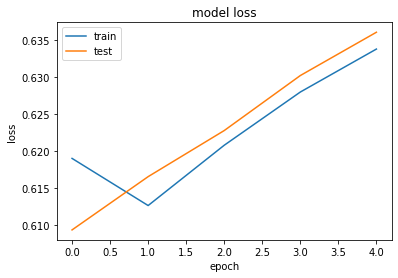

In [34]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

Read Movies Dataframe

In [35]:
column_names = ['MovieID', 'Title', 'Genres']
movies = pd.read_csv("ml-1m/movies.dat", sep = "::", names = column_names, encoding='latin-1', engine='python')
movies.head() 

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [36]:
movie_df = movies

In [37]:
user_id = df.User_ID.sample(1).iloc[0]  # Choose User randomly.
movies_watched_by_user = df[df.User_ID == user_id]  # Take movies wathec by the user.
movies_not_watched = movie_df[
    ~movie_df["MovieID"].isin(movies_watched_by_user.MovieID.values)
]["MovieID"]  # Define not watched movies by user.
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
movies_not_watched = np.asarray(movies_not_watched)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)  # Create User - Not watched movie ID mapping.

In [38]:
user_movie_array = user_movie_array[user_movie_array[:,1] != None]  # Discard NoneType values to get rid of problems in the prediction part.
user_movie_array = np.int64(user_movie_array)

Predict and Recommend 5 Most Relevant Movies according to High-Rating Movies from User

In [39]:
ratings = model.predict(user_movie_array)
ratings = np.array([a[0] for a in ratings])
top_ratings_indices = (-ratings).argsort()[:5]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
    ]
print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="Rating", ascending=False)
    .head(5)
    .MovieID.values
)
movie_df_rows = movie_df[movie_df["MovieID"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.Title, ":", row.Genres)

print("----" * 8)
print("Top 5 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["MovieID"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.Title, ":", row.Genres)

Showing recommendations for user: 4318
Movies with high ratings from user
--------------------------------
Leaving Las Vegas (1995) : Drama|Romance
Sound of Music, The (1965) : Musical
Deer Hunter, The (1978) : Drama|War
When Harry Met Sally... (1989) : Comedy|Romance
Bug's Life, A (1998) : Animation|Children's|Comedy
--------------------------------
Top 5 movie recommendations
--------------------------------
Cyclo (1995) : Crime|Drama
Maybe, Maybe Not (Bewegte Mann, Der) (1994) : Comedy
Supercop (1992) : Action|Thriller
